In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *
import ssm

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''


class PredictiveDensity:
    def __init__(self, mu, sigma):
        if mu.ndim == 1:
            self.mu = np.array([mu]).T
        else:
            self.mu = np.array(mu)
        if sigma.ndim == 1:
            self.Sigma = np.array([sigma]).T
        else:    
            self.Sigma = np.array(sigma)
            
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs, conv_crit=1e-4)
    hs_model.run()
    
    return hs_model

def train_nonlinear_SSM(x_tr, **kwargs):
    '''
    to be updated; currently doesn't run
    LSEMStateModel -> sm_hs = state_models.LSEMStateModel(args.dz,args.dk# + param for basis func)
    '''
    nonlin_model = NonLinearStateSpace_EM(x_tr,args.dz, args.dk)
    nonlin_model.run()
    
    return nonlin_model

class HMM_class:
    
    def __init__(self, x_tr, K, obs_model='gaussian'):
        self.x_tr = x_tr
        self.D = x_tr.shape[1]
        self.K = K
        self.obs_model = obs_model
        self.model = self._train()
        
    def _train(self):
        model = ssm.HMM(self.K, self.D, observations=self.obs_model)
        model.fit(self.x_tr, method="em")
        return model

    def compute_predictive_log_likelihood(self, x_te):
        return self.model.log_likelihood(x_te)
    
    def compute_predictive_density(self, x_te):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        if self.obs_model == 'gaussian' or  self.obs_model == 'studentst':
            mean_te = np.dot(states, self.model.observations.mus)
        elif self.obs_model == 'ar':
            mean_te = np.sum(states[:,:,None] * (np.sum(self.model.observations.As[None] * x_te[:,None, None], axis=3) + self.model.observations.bs), axis=1)
        std_te = np.dot(states, np.sqrt(self.model.observations.Sigmas.diagonal(axis1=1, axis2=2)))
        print(mean_te.shape, std_te.shape)
        return PredictiveDensity(mean_te, std_te ** 2)

def train_HMM(x_tr, num_states, **kwargs):
    return HMM_class(x_tr, num_states)


class ARIMAX:
    
    def __init__(self, x_tr, p, q):
        self.x_tr = x_tr
        self.p = p_arimax
        self.q = q_arimax
        self._train()
        
    def _train(self):
        if x_tr.shape[1] == 1:
            self.mod = sm.tsa.statespace.SARIMAX(x_tr, trend='c', order=(self.p,0,self.q))
            self.fit_res = self.mod.fit(disp=False)
        else:
            self.mod = sm.tsa.VARMAX(x_tr, trend='c', order=(self.p,self.q))
            self.fit_res = self.mod.fit(disp=False, max_iter=1000)
            
    def compute_predictive_density(self, x_te):
        mod_te = self.mod.clone(x_te)
        res = mod_te.filter(self.fit_res.params)
        predict = res.get_prediction()
        predict_ci = predict.conf_int(alpha=1.-.68)
        mu = predict.predicted_mean
        if x_te.shape[1] == 1:
            std = predict.predicted_mean - predict_ci[:,0]
        else:
            std = predict.predicted_mean - predict_ci[:,:x_te.shape[1]]
        return PredictiveDensity(mu, std ** 2)
            
    def compute_predictive_log_likelihood(self, x_te):  
        mod_te = self.mod.clone(x_te)
        return mod_te.loglike(self.fit_res.params)
    
def train_arimax(x_tr, **kwargs):
    
    arimax_model = ARIMAX(x_tr)
    return arimax_model

In [2]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_synthetic_e1(train_ratio=.75)
dz = 3
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True)

Iteration 2 - llk=-7206.5
Iteration 4 - llk=7215.0
Iteration 6 - llk=16181.0
Iteration 8 - llk=23109.1
Iteration 10 - llk=27133.6
Iteration 12 - llk=28586.3
Iteration 14 - llk=28880.1
Iteration 16 - llk=28936.0
EM did converge.


In [ ]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_synthetic_e1(train_ratio=.75)
dz = 5
du = 4
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True)

In [ ]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_synthetic_e1(train_ratio=.75)
K = 18
hmm = train_HMM(x_tr, K)

In [ ]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_synthetic_e1(train_ratio=.75)
p, q = 4, 1
arimax = train_arimax(x_tr, p, q)

In [118]:
mask = np.logical_not(np.isnan(x_te_original))
x_te_not_nan = np.zeros(x_te_original.shape)
x_te_not_nan[mask] = x_te_original[mask]
states = hmm.model.filter(x_te_not_nan, mask=mask)
llk_states = numpy.empty(states.shape)
for k in range(hmm.K):
    mu, Sigma  = hmm.model.observations.mus[k], hmm.model.observations.Sigmas[k]
    llk_states[:,k] = scipy.stats.multivariate_normal(mu, Sigma).logpdf(x_te_original)

In [123]:
numpy.sum(scipy.special.logsumexp(llk_states, axis=1, b=states)[:])

6317.889526761824

In [77]:
hmm.compute_predictive_log_likelihood(x_te_original)

6317.889526761833

In [ ]:
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_original)
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_original)
hmm_pred_density = hmm.compute_predictive_density(x_te_original)
arimax_pred_density = arimax.compute_predictive_density(x_te_original)

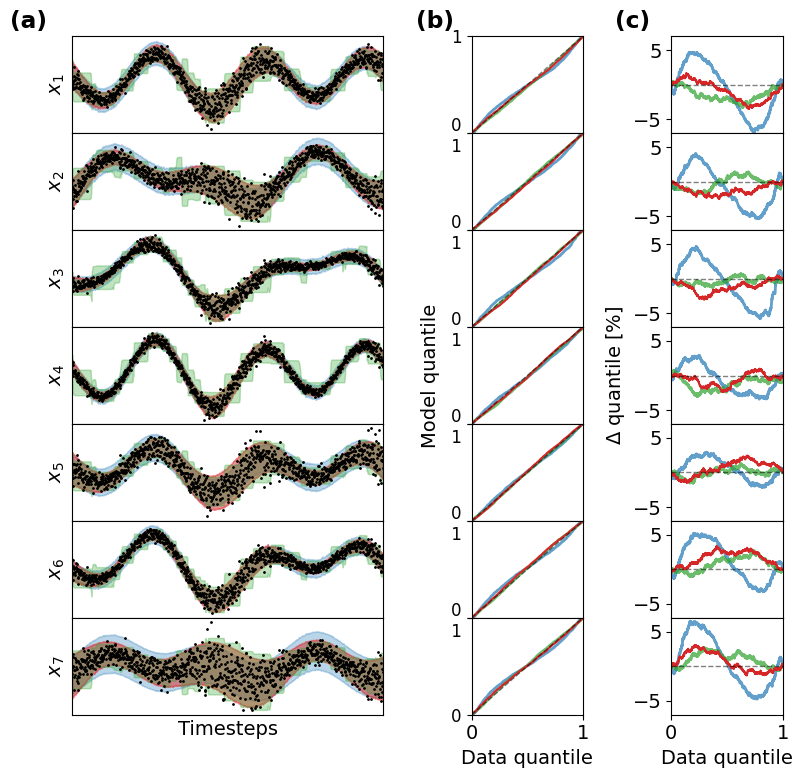

In [177]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(8,8))
gs = fig.add_gridspec(7, 4, hspace=0)
T_start = 10
T_stop = 1010
for dx in range(ssm_em_lin.Dx):
    ax1 = fig.add_subplot(gs[dx,:2])
    ax1.plot(range(T_start,T_stop), x_te_original[T_start:T_stop, dx], 'k.', ms=2)
    lb_lin = lin_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop, dx, dx])
    ub_lin = lin_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop, dx, dx])
    ax1.fill_between(range(T_start,T_stop), lb_lin, ub_lin, color='C0', alpha=.3)
    lb_hsk = hsk_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop, dx, dx])
    ub_hsk = hsk_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop, dx, dx])
    ax1.fill_between(range(T_start,T_stop), lb_hsk, ub_hsk, color='C3', alpha=.5)
    lb_hmm = hmm_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop, dx])
    ub_hmm = hmm_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop, dx])
    ax1.fill_between(range(T_start,T_stop), lb_hmm, ub_hmm, color='C2', alpha=.3)
    lb_arimax = arimax_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop, dx])
    ub_arimax = arimax_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop, dx])
    ax1.fill_between(range(T_start,T_stop), lb_arimax, ub_arimax, color='C4', alpha=.3)
    ax1.set_xlim([T_start,T_stop])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('$x_%d$' %(dx+1))
    
    ax2 = fig.add_subplot(gs[dx,2])
    hsk_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hsk_pred_density.mu[:,dx]) / numpy.sqrt(hsk_pred_density.Sigma[:,dx,dx])))
    lin_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - lin_pred_density.mu[:,dx]) / numpy.sqrt(lin_pred_density.Sigma[:,dx,dx])))
    hmm_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hmm_pred_density.mu[:,dx]) / numpy.sqrt(hmm_pred_density.Sigma[:,dx])))
    arimax_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - arimax_pred_density.mu[:,dx]) / numpy.sqrt(arimax_pred_density.Sigma[:,dx])))
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), lin_cdf, color='C0', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hmm_cdf, color='C2', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hsk_cdf, color='C3', alpha=1)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), arimax_cdf, color='C4', alpha=1)
    ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.set_xticks([])
    ax2.set_yticks([0,1])
    if dx == 0:
        ax2.set_yticklabels(labels=['','1'], fontsize=12)
    else:
        ax2.set_yticklabels(labels=['','0\n 1'], fontsize=12)
    
    ax3 = fig.add_subplot(gs[dx,3])
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (lin_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C0', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hmm_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C2', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (arimax_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C4', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hsk_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C3')
    ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
    ax3.set_xlim([0,1])
    #ax2.set_ylim([0,1])
    ax3.set_xticks([])
    ax3.set_yticks([-5,5])
    ax3.set_ylim([-7,7])
    if dx == 3:
        ax2.set_ylabel('Model quantile')
        ax3.set_ylabel('$\Delta$ quantile [%]')
    if dx == 0:
        ax1.set_title('(a)', loc='left', fontweight='bold', x=-.2)
        ax2.set_title('(b)', loc='left', fontweight='bold', x=-.5)
        ax3.set_title('(c)', loc='left', fontweight='bold', x=-.5)

ax1.set_xlabel('Timesteps')
ax2.set_xticks([0,1])
ax3.set_xticks([0,1])
ax2.set_xticks([0,1])
ax2.set_xlabel('Data quantile')
ax2.set_yticklabels(labels=['0','0\n 1'], fontsize=12)
ax3.set_xlabel('Data quantile')
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/synthetic.pdf')
fig.savefig('../../figs/aistats22/synthetic.png', dpi=600)

In [396]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_synthetic', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_synthetic', path='../../data/models/')

In [405]:
x_te = numpy.copy(x_te_original)
x_te[1510:2010,0] = numpy.linspace(0,6,500) + numpy.random.randn(*x_te[1510:2010,0].shape) + 1
#x_te[1710:2010,2:] -= 
x_te[810:1210,1] = numpy.nan
x_te[1710:2010,2:] = numpy.nan#numpy.linspace(0,10,200)[:,None] + numpy.random.randn(*x_te[710:910,2:].shape) 

In [406]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

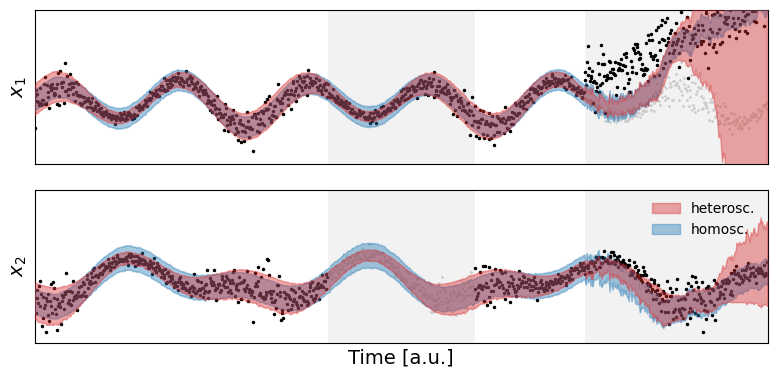

In [434]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

start_idx, stop_idx, step = 10, 2010, 2
num_steps = len(numpy.arange(start_idx, stop_idx, step))
fig = pyplot.figure(figsize=(8,4))
for idx in range(2):
    ax = fig.add_subplot(2,1,idx+1)
    pyplot.plot(x_te_original[start_idx:stop_idx:step,idx], '.', ms=2, color=[.8,.8,.8])
    pyplot.plot(x_te[start_idx:stop_idx:step,idx], '.', ms=3, color='k')
    pyplot.fill_between(range(num_steps), mu_hsk[start_idx:stop_idx:step,idx] - 1.68 * std_hsk[start_idx:stop_idx:step,idx], mu_hsk[start_idx:stop_idx:step,idx] + 1.69 * std_hsk[start_idx:stop_idx:step,idx], color='C3', alpha=.4, zorder=9, label='heterosc.')
    pyplot.fill_between(range(num_steps), mu_lin[start_idx:stop_idx:step,idx] - 1.68 * std_lin[10:1010,idx], mu_lin[start_idx:stop_idx:step,idx] + 1.68 * std_lin[start_idx:stop_idx:step,idx], color='C0', alpha=.4, zorder=7, label='homosc.')
    pyplot.xlim([0,num_steps])
    pyplot.xticks([], labels=[])
    pyplot.yticks([])
    pyplot.ylim([-4,6])
    pyplot.fill_between([400,600], -4, 6, facecolor='gray', alpha=.1)
    pyplot.fill_between([750,1000], -4, 6, facecolor='gray', alpha=.1)
    pyplot.ylabel('$x_%d$' %(idx+1))
pyplot.xticks([], labels=[])
pyplot.legend(frameon=False, fontsize=10)
idx = 2
pyplot.xlabel('Time [a.u.]')

#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')
fig.tight_layout()
fig.savefig('../../figs/aistats22/motivational_figure.pdf')
fig.savefig('../../figs/aistats22/motivational_figure.png', dpi=600)

In [204]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_synthetic_e1()

In [3]:
smooth_window = 20
dz, du = observation_models.recommend_dims(x_tr, smooth_window=20)

In [72]:
dz, du

(2, 3)

In [6]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_synthetic_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True, smooth_window=smooth_window)

Iteration 2 - llk=5597.0
Iteration 4 - llk=13149.0
Iteration 6 - llk=14927.6
Iteration 8 - llk=16065.7
Iteration 10 - llk=17138.5
Iteration 12 - llk=18209.8
Iteration 14 - llk=19340.7
Iteration 16 - llk=20427.9
Iteration 18 - llk=21197.6
Iteration 20 - llk=21503.7
Iteration 22 - llk=21577.6
EM did converge.


In [7]:
ssm_em_hsk.save(model_name='ssm_em_hsk_synthetic', path='../../data/models/')

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_synthetic_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True, smooth_window=smooth_window)

Iteration 2 - llk=-4909.7
Iteration 4 - llk=4507.4
Iteration 6 - llk=10526.0
Iteration 8 - llk=15237.9
Iteration 10 - llk=17986.6
Iteration 12 - llk=18955.2
Iteration 14 - llk=19145.2
Iteration 16 - llk=19179.5
EM did converge.


In [5]:
ssm_em_lin.save(model_name='ssm_em_lin_synthetic', path='../../data/models/')

In [7]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

19083.306151229146

In [8]:
ssm_em_hsk.compute_predictive_log_likelihood(x_te)

22228.611029293275

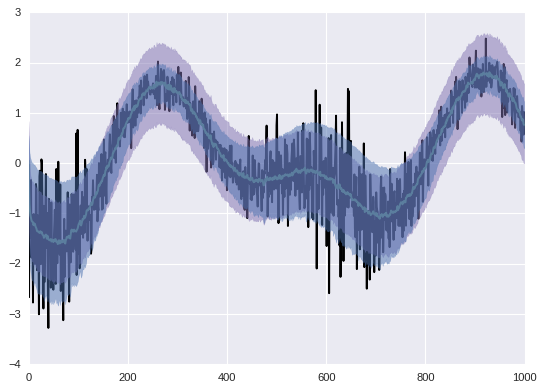

In [60]:
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

idx = 1
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.plot(x_te[:1000,idx], 'k')
pyplot.plot(mu_hsk[:1000,idx], color='C1')
pyplot.fill_between(range(1000), mu_hsk[:1000,idx] - 1.68 * std_hsk[:1000,idx], mu_hsk[:1000,idx] + 1.68 * std_hsk[:1000,idx], color='C0', alpha=.5, zorder=9)
pyplot.fill_between(range(1000), mu_lin[:1000,idx] - 1.68 * std_lin[:1000,idx], mu_lin[:1000,idx] + 1.68 * std_lin[:1000,idx], color='C3', alpha=.5, zorder=7)

In [59]:
import matplotlib as mpl
mpl.style.use('seaborn')

In [22]:
mpl.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [41]:
del pyplot

In [42]:
from matplotlib import pyplot

In [52]:
pyplot.style.reload_library()

In [61]:
import pickle

In [65]:
pickle.dump(ssm_em_lin, open('../../data/models/%s_%s.p' %('ssm_em_lin', 'synthetic'), 'wb'))

In [64]:
pickle.dump(ssm_em_hsk, open('../../data/models/%s_%s.p' %('ssm_em_hsk', 'synthetic'), 'wb'))

In [4]:
pyplot.rcdefaults()